# Pre - Work

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install qiskit>=2 qiskit-algorithms qiskit-aer pylatexenc

In [ ]:
!cp -r "/content/drive/MyDrive/Projects/QBMs/Implementation/pyqbm2" "./"

# QBM Model

## Imports

In [ ]:
from pyqbm2.ute import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

## Hyperparameters

In [ ]:
N_COND = 2
N_VIS = 5
N_HID = 2
N_QUBITS = N_COND + N_VIS + N_HID
N_LAYERS = 5
EPOCHS = 50
N_COND_STATES = 4
N_VIS_STATES = 2**N_VIS

## Data Preperation

Target conditional distributions (close plot to continue)…


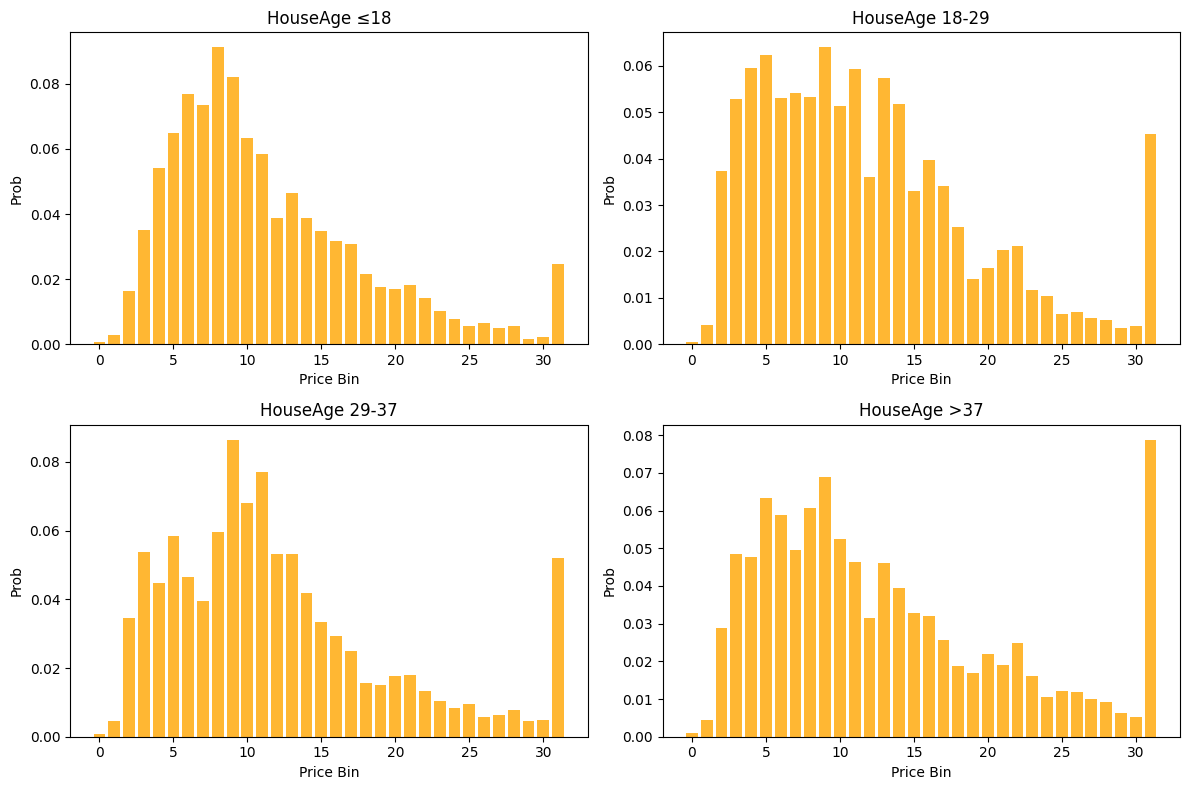

In [ ]:
dataOracle = DataOracle()
target_cond_dist, age_bins = dataOracle.load(
    N_COND_STATES,
    N_VIS_STATES,
    show=True
)

## Quantum Oracle Preperation

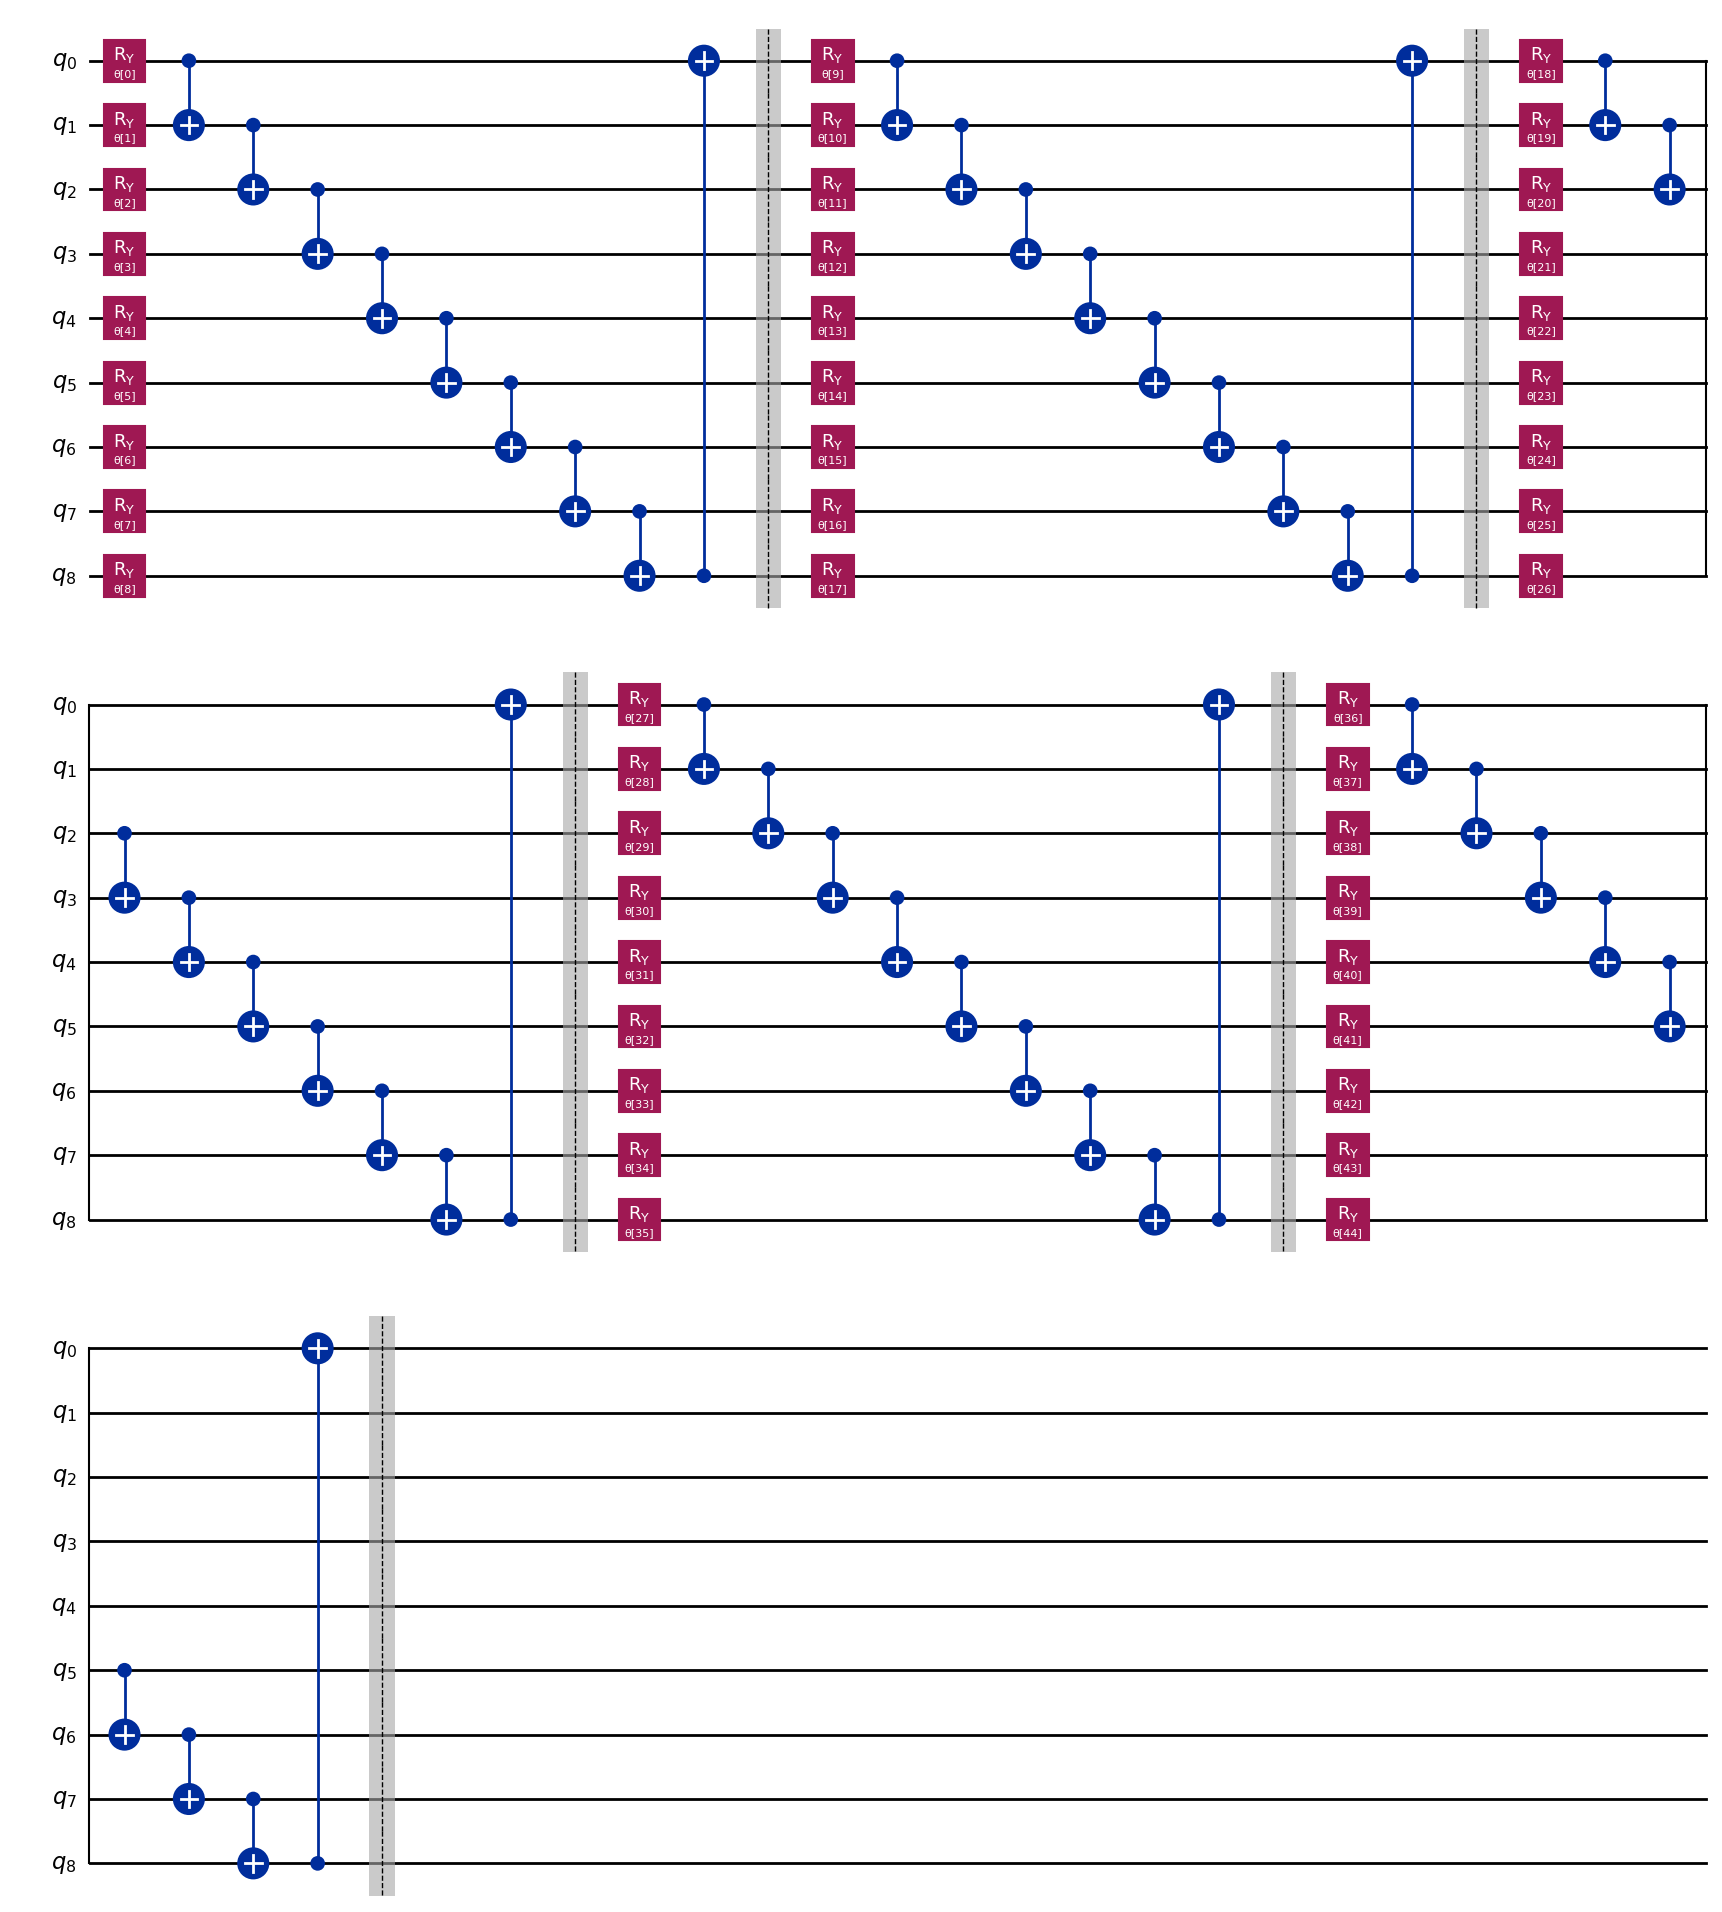

In [ ]:
ansatzOracle = AnsatzOracle(N_QUBITS, N_LAYERS)
cir = ansatzOracle.getCircuit()
cir.draw('mpl')

In [ ]:
projectorOracle = ProjectorOracle(N_VIS, N_COND, N_HID)

## Training


Training started with 45 parameters for 50 epochs.
Epoch   0 | Loss: 1.348024


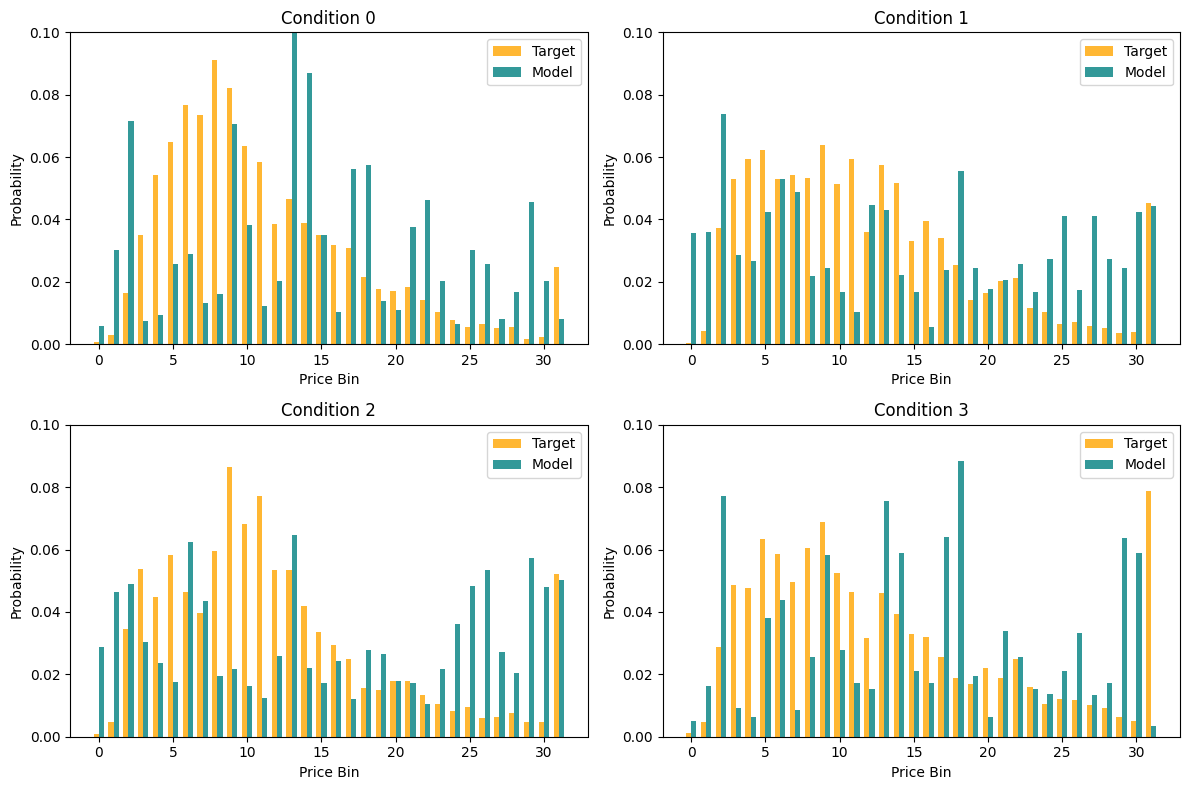

In [ ]:
cqbm = CQbmOracle(
    ansatz=ansatzOracle,
    projector=projectorOracle,
    nCondStates=N_COND_STATES
)

initialParams = np.random.uniform(0, 2 * np.pi, ansatzOracle.totalParams)
finalParams, lossHistory = cqbm.trainAdam(
    initialParams,
    target_cond_dist,
    epochs=EPOCHS,
    show=True
)

## Generating Data

In [ ]:
conditionStr = "10"
for _ in range(2):
    binIdx = cqbm.genData(conditionStr)
    minPrice, maxPrice = dataOracle.decode(binIdx, nVisStates=N_VIS_STATES)

    print(f"Condition: {conditionStr}")
    print(f"Generated Bin: {binIdx}")
    print(f"Price Range: ${minPrice:,.2f} - ${maxPrice:,.2f}")
    print()

Condition: 10
Generated Bin: 13
Price Range: $212,031.06 - $227,187.37

Condition: 10
Generated Bin: 10
Price Range: $166,562.12 - $181,718.44



## Post Training Plot

Final comparison (close plot)…


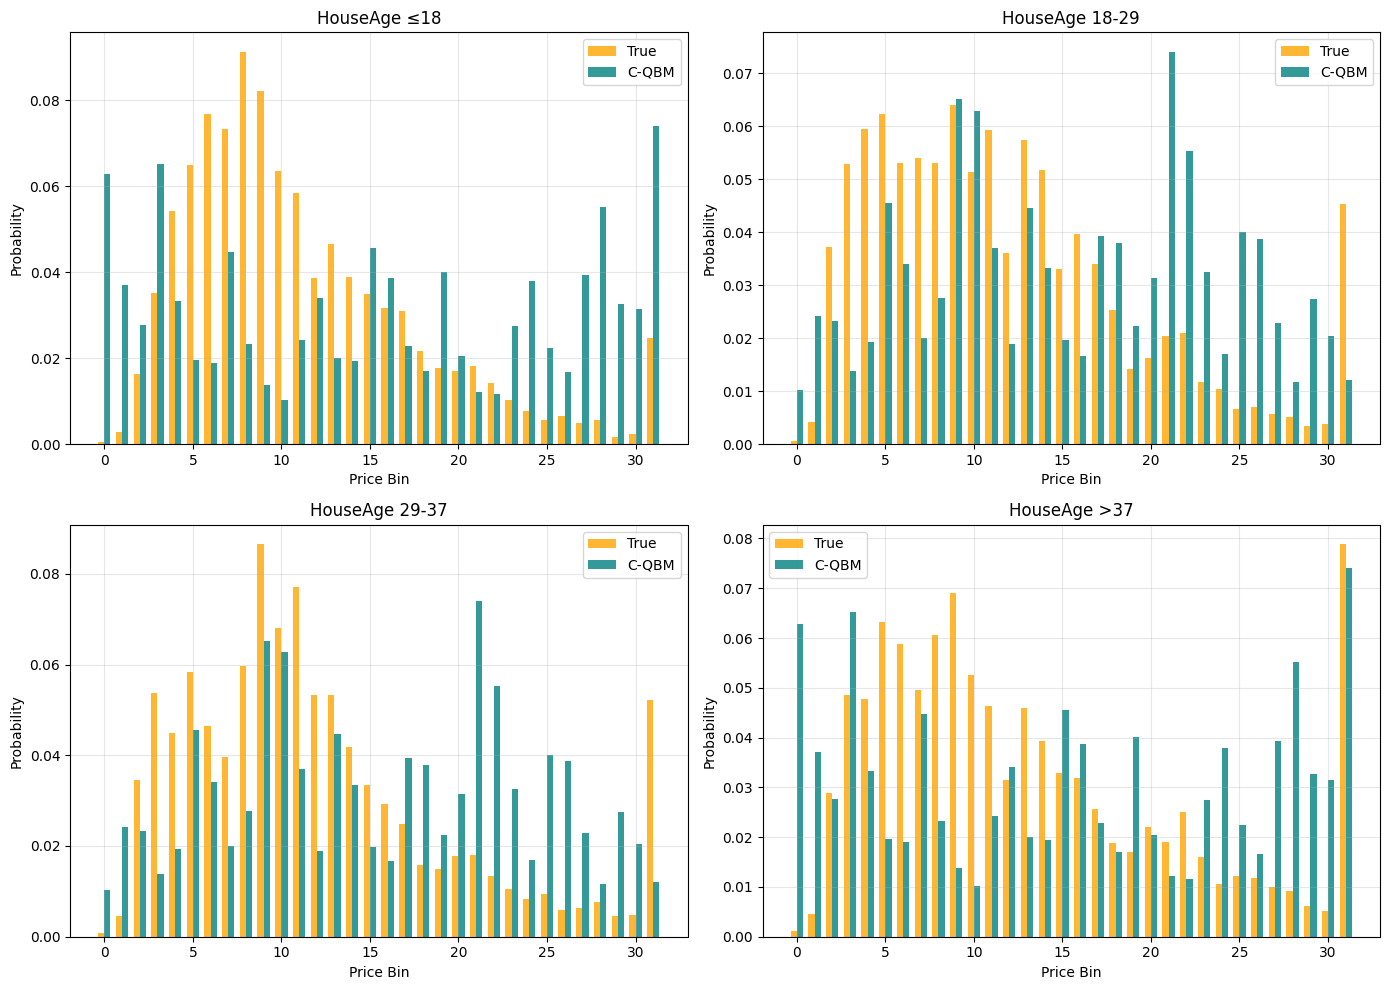

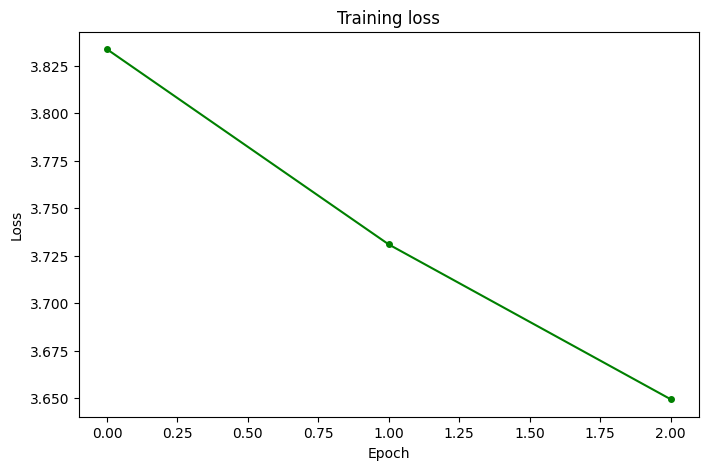

Avg JSD: 0.1046


In [ ]:
cqbm.plotResults(
    finalParams,
    target_cond_dist,
    lossHistory,
    age_bins=age_bins,
    show=True
)

## Loss Calculation

In [ ]:
conditions = ['00', '01', '10', '11']

losses, avg_loss = cqbm.calculate_loss(target_cond_dist, option='kl')
losses_rkl, avg_rkl = cqbm.calculate_loss(target_cond_dist, option='klrkl1')

print(f"Losses Table:")
display(pd.DataFrame({
    'Condition': conditions,
    'KL Loss': list(losses.values()),
    'KL/RKL-1 Loss': list(losses_rkl.values())
}).set_index('Condition'))

print(f"Average KL loss: {avg_loss:.4f}")
print(f"Average KLRKL1 loss: {avg_rkl:.4f}")

Losses Table:


,KL Loss,KL/RKL-1 Loss
Condition,,
00,0.610925,1.631079
01,0.319947,1.009025
10,0.332406,1.040439
11,0.408384,1.161565


Average KL loss: 0.4179
Average KLRKL1 loss: 1.2105


## For 1 Condition

Prob Dist is [0.06283676 0.0370607  0.02765801 0.06515199 0.03335399 0.01967196
 0.0189729  0.0446931  0.02333183 0.01376096 0.01026966 0.0241915
 0.03401231 0.02006023 0.01934738 0.04557522 0.03866567 0.02280475
 0.01701895 0.04009031 0.02052388 0.01210485 0.01167469 0.02750123
 0.03791728 0.02236336 0.01668954 0.03931435 0.05527444 0.0326005
 0.03144201 0.07406569]


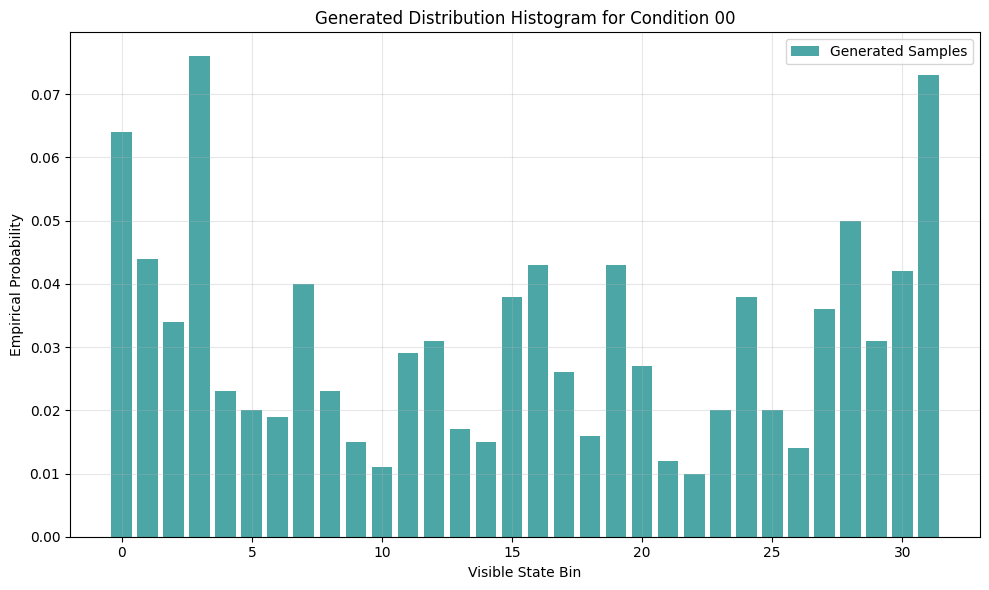

In [ ]:
p_gen = cqbm.generate('00')
print("Prob Dist is", p_gen)
cqbm.plot('00', n_samples=1000)

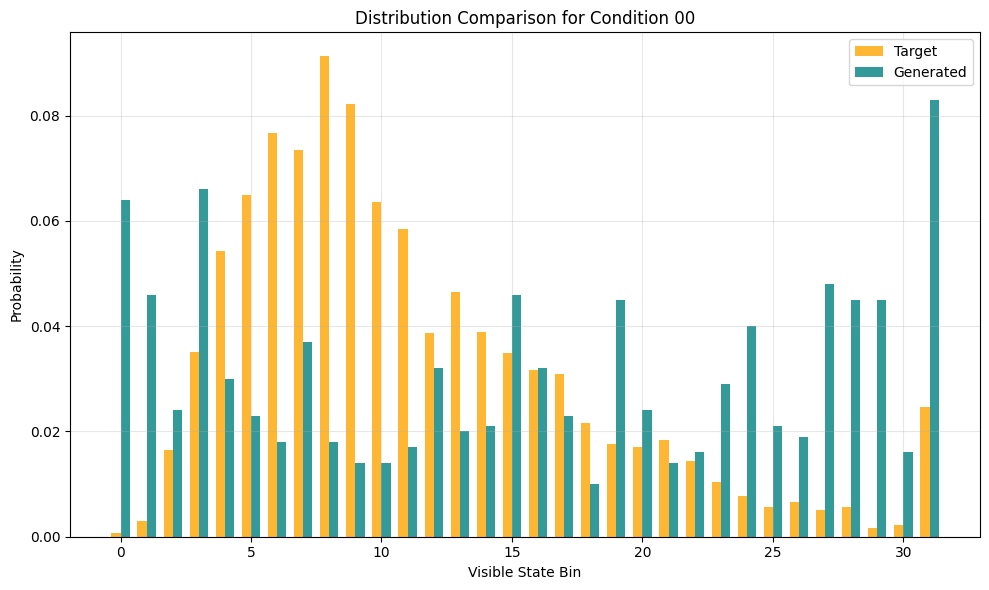

In [ ]:
cqbm.compare(
    condition='00',
    n_samples=1000,
    target_dist=target_cond_dist[0]
)

## For All Conditions

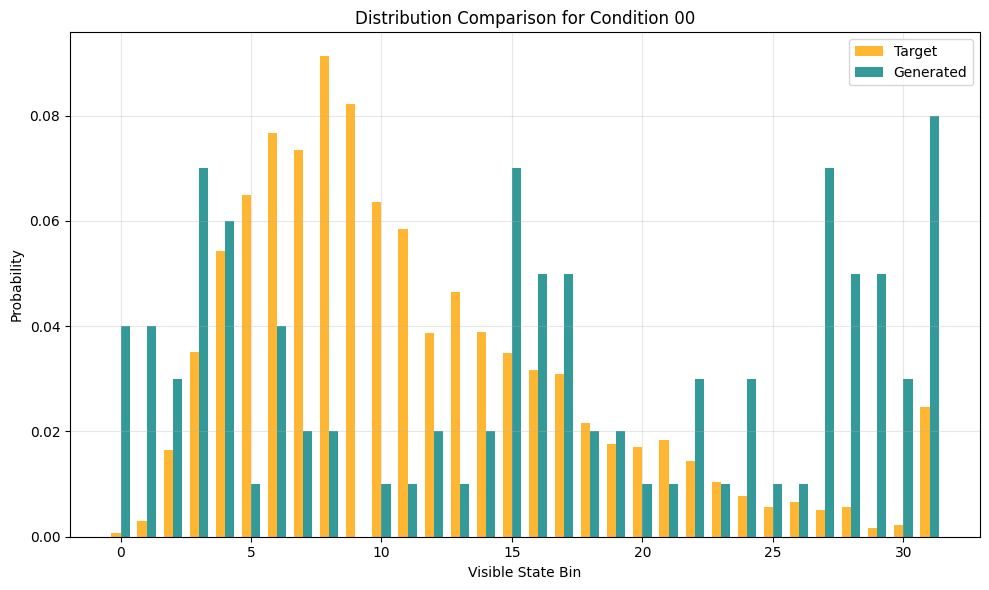

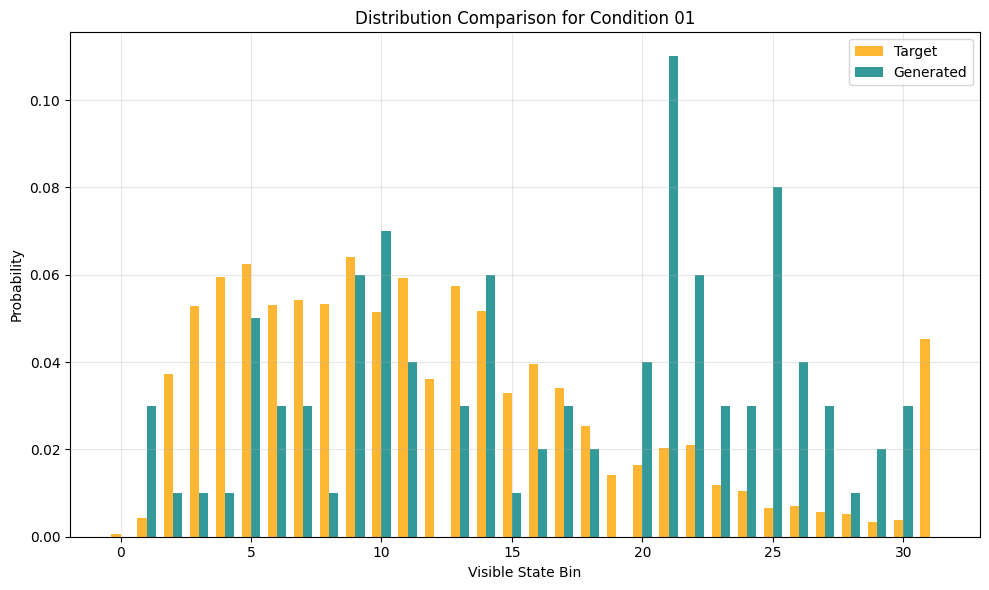

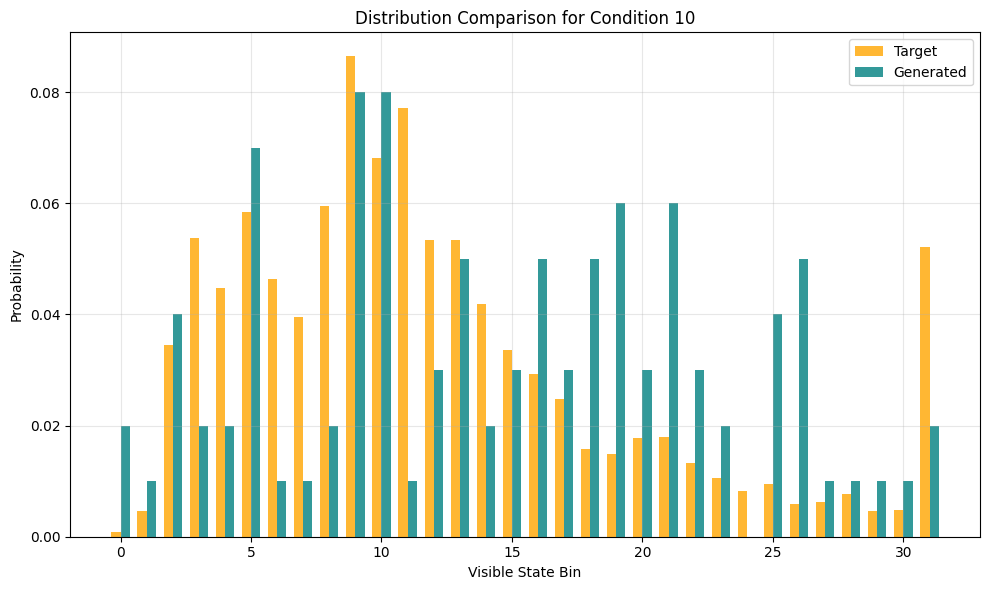

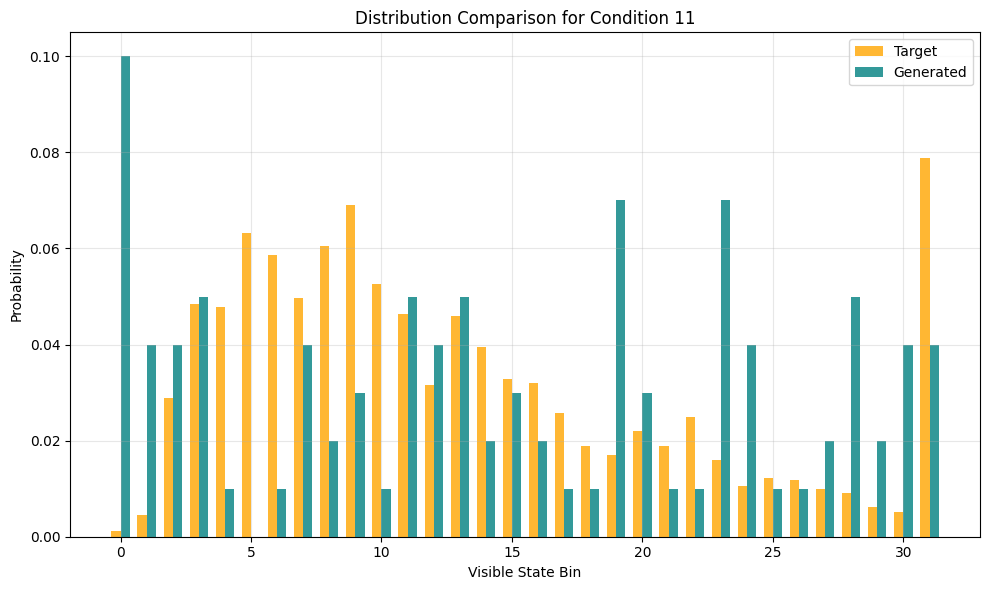

In [ ]:
for i,c in enumerate(conditions):
    cqbm.compare(
        condition=c,
        n_samples=100,
        target_dist=target_cond_dist[i]
    )

## Saving

In [ ]:
cqbm.save(file_path='demo.json')
print("\nModel saved to demo.json")


Model saved to demo.json


# Trained Model

## Loading

In [ ]:
!cp "/content/drive/MyDrive/Projects/QBMs/Implementation/trained.json" "./"

In [ ]:
model = CQbmOracle('trained.json')
print("\nModel loaded from trained.json")


Model loaded from trained.json


## Loss Calc

In [ ]:
conditions = ['00', '01', '10', '11']

losses, avg_loss = model.calculate_loss(target_cond_dist, option='kl')
losses_rkl1, avg_rkl1 = model.calculate_loss(target_cond_dist, option='klrkl1')
losses_rkl2, avg_rkl2 = model.calculate_loss(target_cond_dist, option='klrkl2')

print(f"Losses Table:")
df = pd.DataFrame({
    'Condition': conditions,
    'KL Loss': list(losses.values()),
    'KL/RKL-1 Loss': list(losses_rkl1.values()),
    'KL/RKL-2 Loss': list(losses_rkl2.values())
}).set_index('Condition')

df.loc['SUM'] = {
    'KL Loss': avg_loss*len(losses),
    'KL/RKL-1 Loss': avg_rkl1*len(losses_rkl1),
    'KL/RKL-2 Loss': avg_rkl2*len(losses_rkl2)
}

df.loc['AVG'] = {
    'KL Loss': avg_loss,
    'KL/RKL-1 Loss': avg_rkl1,
    'KL/RKL-2 Loss': avg_rkl2
}

df

Losses Table:


,KL Loss,KL/RKL-1 Loss,KL/RKL-2 Loss
Condition,,,
00,0.037120,0.222395,0.084519
01,0.038399,0.245220,0.087675
10,0.031833,0.211194,0.079057
11,0.050793,0.253262,0.110581
SUM,0.158145,0.932070,0.361831
AVG,0.039536,0.233017,0.090458


## For 1 Condition

Prob Dist is [0.00492831 0.00692001 0.02648906 0.02885308 0.05854346 0.06423414
 0.05481698 0.06134258 0.08705378 0.07339488 0.05426991 0.05954157
 0.04152484 0.0405375  0.0396452  0.02888298 0.02828904 0.03572863
 0.01547596 0.01366915 0.01986876 0.02006864 0.01589705 0.01405806
 0.01434162 0.01078295 0.01032264 0.00826852 0.00747226 0.00768266
 0.01693312 0.03016265]


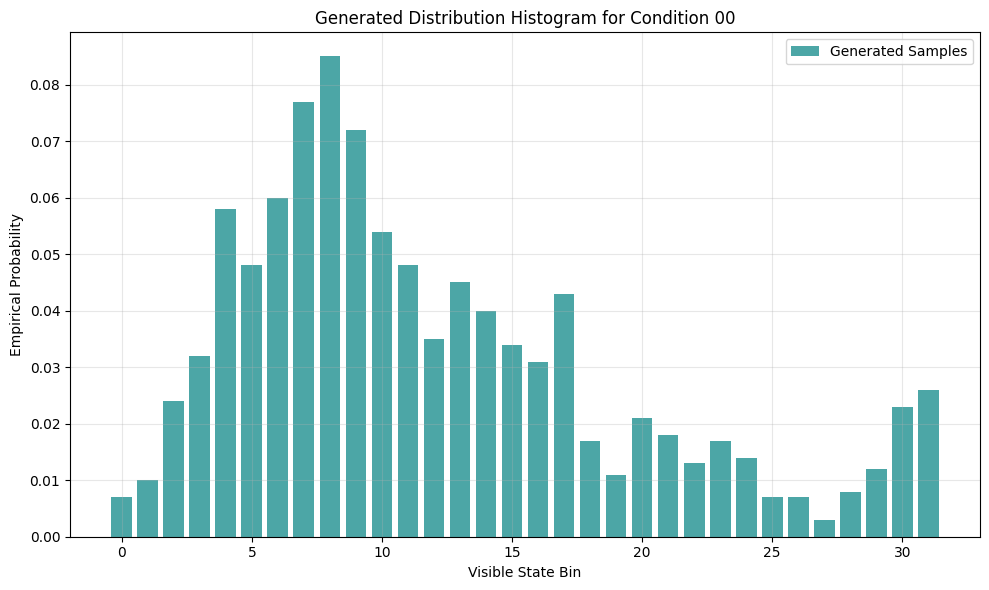

In [ ]:
p_gen = model.generate('00')
print("Prob Dist is", p_gen)
model.plot('00', n_samples=1000)

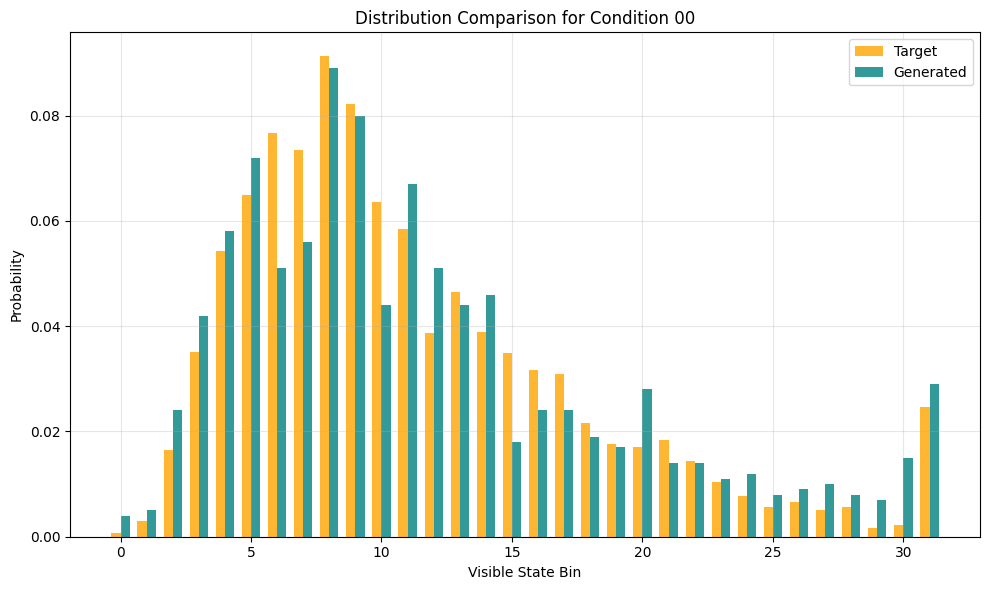

In [ ]:
model.compare(
    condition='00',
    n_samples=1000,
    target_dist=target_cond_dist[0]
)

## For All Conditions

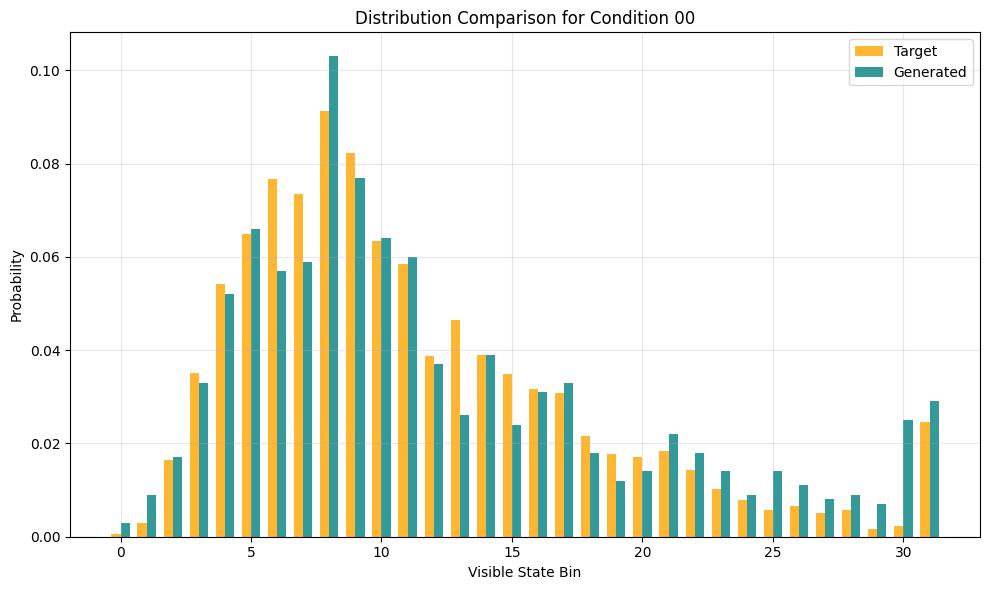

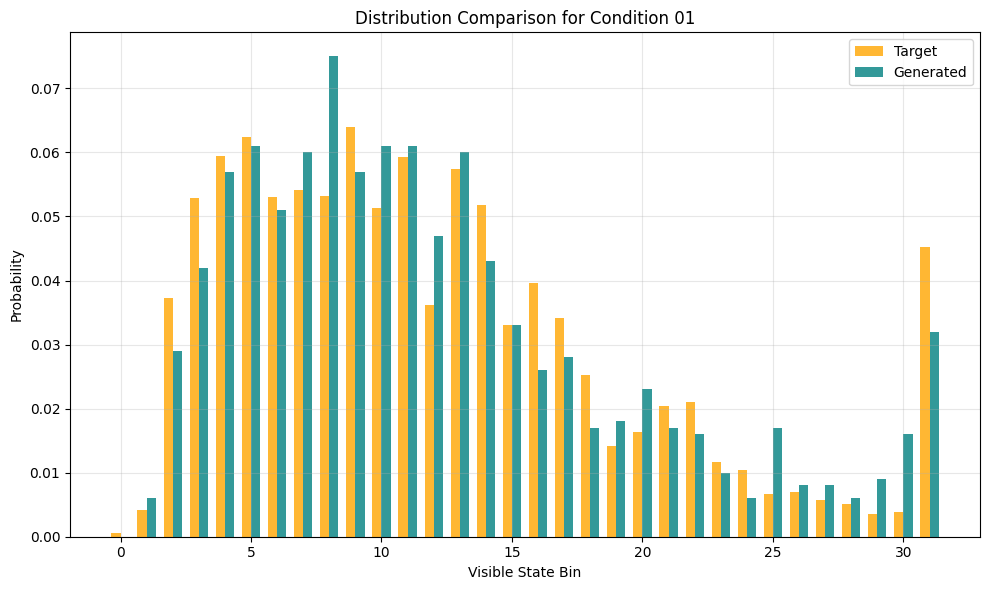

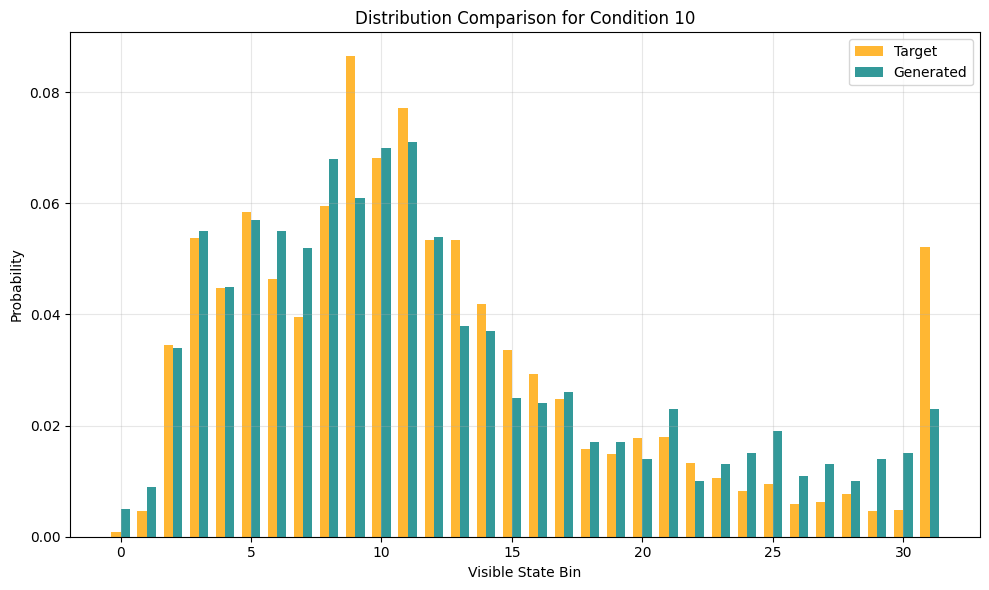

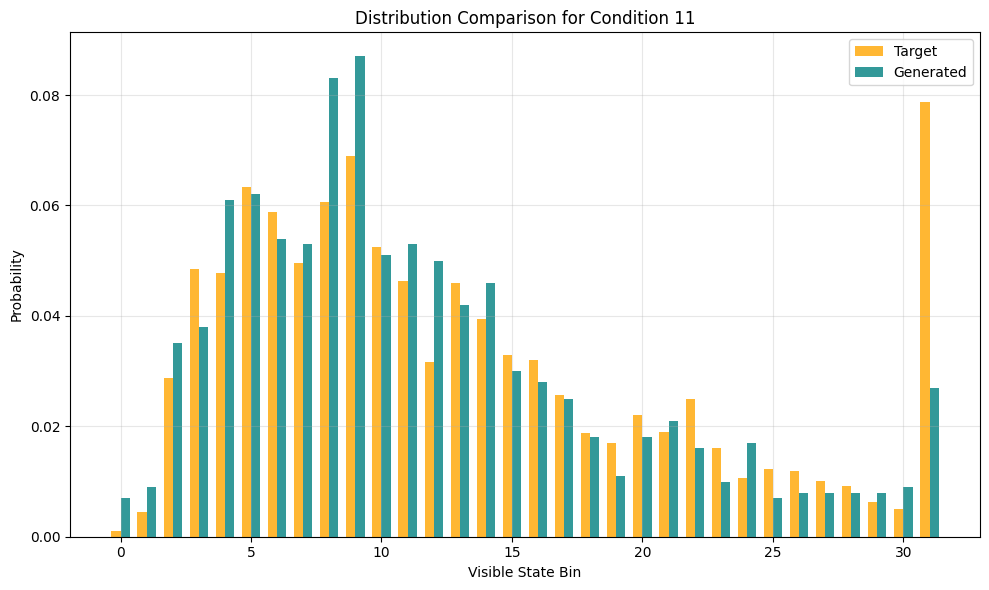

In [ ]:
for i, c in enumerate(conditions):
    model.compare(
        condition=c,
        n_samples=1000,
        target_dist=target_cond_dist[i]
    )

## Gen Data

In [ ]:
for c in ['11']:
    for _ in range(10):
        binIdx = model.genData(c)
        minPrice, maxPrice = dataOracle.decode(binIdx, nVisStates=N_VIS_STATES)

        print(f"Condition: {c}")
        print(f"Generated Bin: {binIdx}")
        print(f"Price Range: ${minPrice:,.2f} - ${maxPrice:,.2f}")
        print()

    print('='*20)

Condition: 11
Generated Bin: 8
Price Range: $136,249.50 - $151,405.81

Condition: 11
Generated Bin: 29
Price Range: $454,532.06 - $469,688.37

Condition: 11
Generated Bin: 16
Price Range: $257,500.00 - $272,656.31

Condition: 11
Generated Bin: 12
Price Range: $196,874.75 - $212,031.06

Condition: 11
Generated Bin: 5
Price Range: $90,780.56 - $105,936.88

Condition: 11
Generated Bin: 5
Price Range: $90,780.56 - $105,936.88

Condition: 11
Generated Bin: 3
Price Range: $60,467.94 - $75,624.25

Condition: 11
Generated Bin: 22
Price Range: $348,437.88 - $363,594.19

Condition: 11
Generated Bin: 12
Price Range: $196,874.75 - $212,031.06

Condition: 11
Generated Bin: 15
Price Range: $242,343.69 - $257,500.00

